In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess prediction label data

Daily Natural Gas Prices:
                   Day  HH_Price
Date                            
1997-01-07   01/7/1997      3.82
1997-01-08   01/8/1997      3.80
1997-01-09   01/9/1997      3.61
1997-01-10  01/10/1997      3.92
1997-01-13  01/13/1997      4.00

Monthly Average Natural Gas Prices:
Date
1997-01-01    3.451053
1997-02-01    2.150526
1997-03-01    1.890500
1997-04-01    2.032727
1997-05-01    2.248095
Freq: MS, Name: HH_Price, dtype: float64


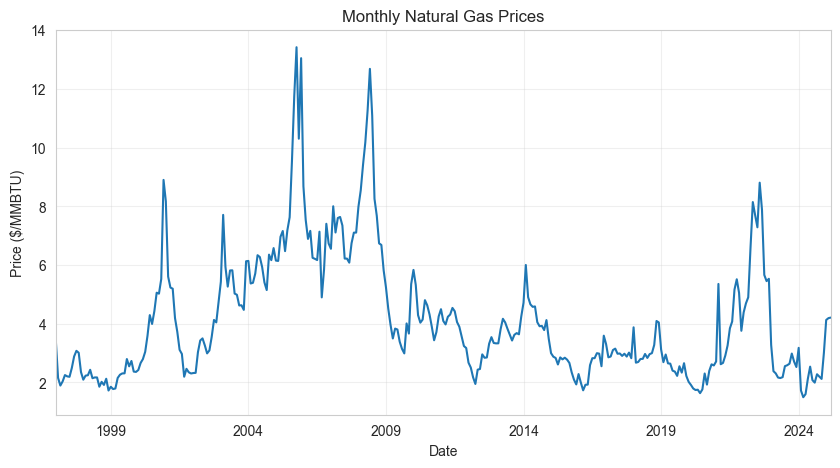

In [ ]:

# Function to load and preprocess NG_SandF.csv
def preprocess_ng_prices(filepath='NG_SandF.csv'):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    header_row = next(i for i, line in enumerate(lines) if "Day" in line and "Henry Hub" in line)
    ng_df = pd.read_csv(filepath, skiprows=header_row)
    ng_df.columns = ng_df.columns.str.strip()
    
    price_col = [col for col in ng_df.columns if "Henry Hub" in col][0]
    ng_df = ng_df.rename(columns={price_col: "HH_Price"})
    
    ng_df['Date'] = pd.to_datetime(ng_df['Day'], format='%m/%d/%Y')
    ng_df['HH_Price'] = pd.to_numeric(ng_df['HH_Price'], errors='coerce')
    
    # Drop rows with missing prices
    ng_df = ng_df.dropna(subset=['HH_Price'])
    
    ng_df = ng_df.sort_values('Date').set_index('Date')
    monthly_ng = ng_df['HH_Price'].resample('MS').mean()
    
    return ng_df, monthly_ng

daily_prices, monthly_prices = preprocess_ng_prices('NG_SandF.csv')

print("Daily Natural Gas Prices:")
print(daily_prices.head())

print("\nMonthly Average Natural Gas Prices:")
print(monthly_prices.head())

monthly_prices.plot(figsize=(10, 5), title='Monthly Natural Gas Prices')
plt.ylabel('Price ($/MMBTU)')
plt.grid(True, alpha=0.3)
plt.show()

# Load and preprocess feature data used to predict Natural gas price

/var/folders/b3/q80vb0m14p9fjtr908bjzvtm0000gn/T/ipykernel_91536/2753517733.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_df['date'] = pd.to_datetime(ts_df['date'])



To use these functions, select from these metrics:
- 'Coal'
- 'Coal Production'
- 'Crude Oil Production'
- 'Crude Oil West Texas Intermediate Spot'
- 'Dry Natural Gas Production'
- 'Electricity'
- 'GDP Implicit Price Deflator'
- 'Liquid Fuels'
- 'Manufacturing Production Index'
- 'Natural Gas'
- 'Natural Gas Henry Hub Spot'
- 'Percent change from prior year'
- 'Real Disposable Personal Income'
- 'Real Gross Domestic Product'
- 'Renewables'
- 'Total Energy Consumption'
- 'U.S. Cooling Degree Days'
- 'U.S. Heating Degree Days'


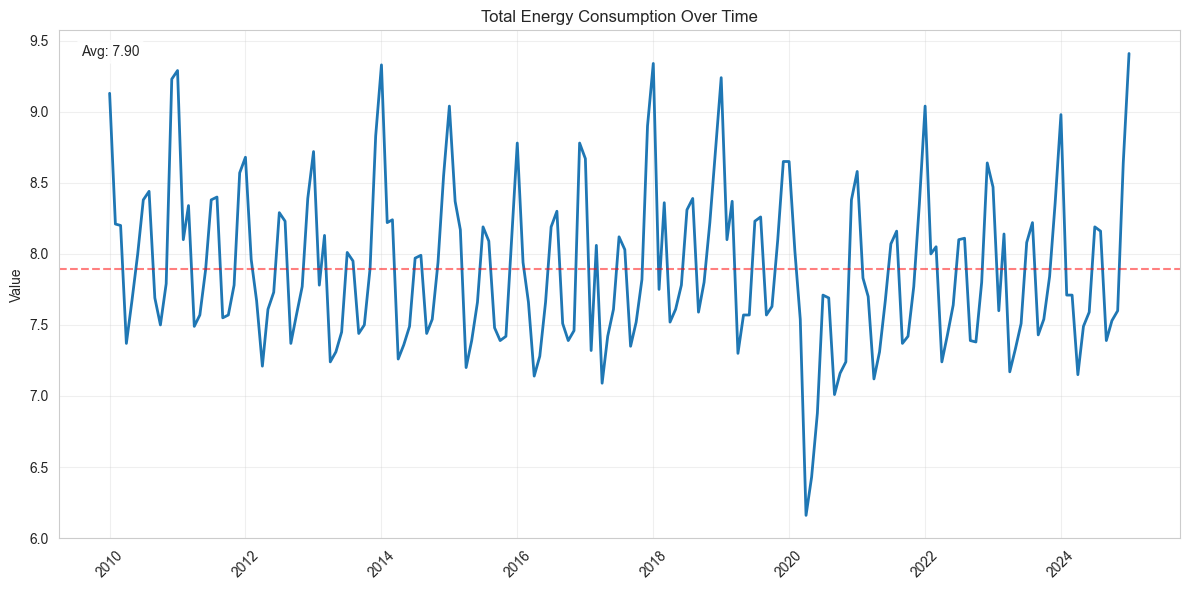

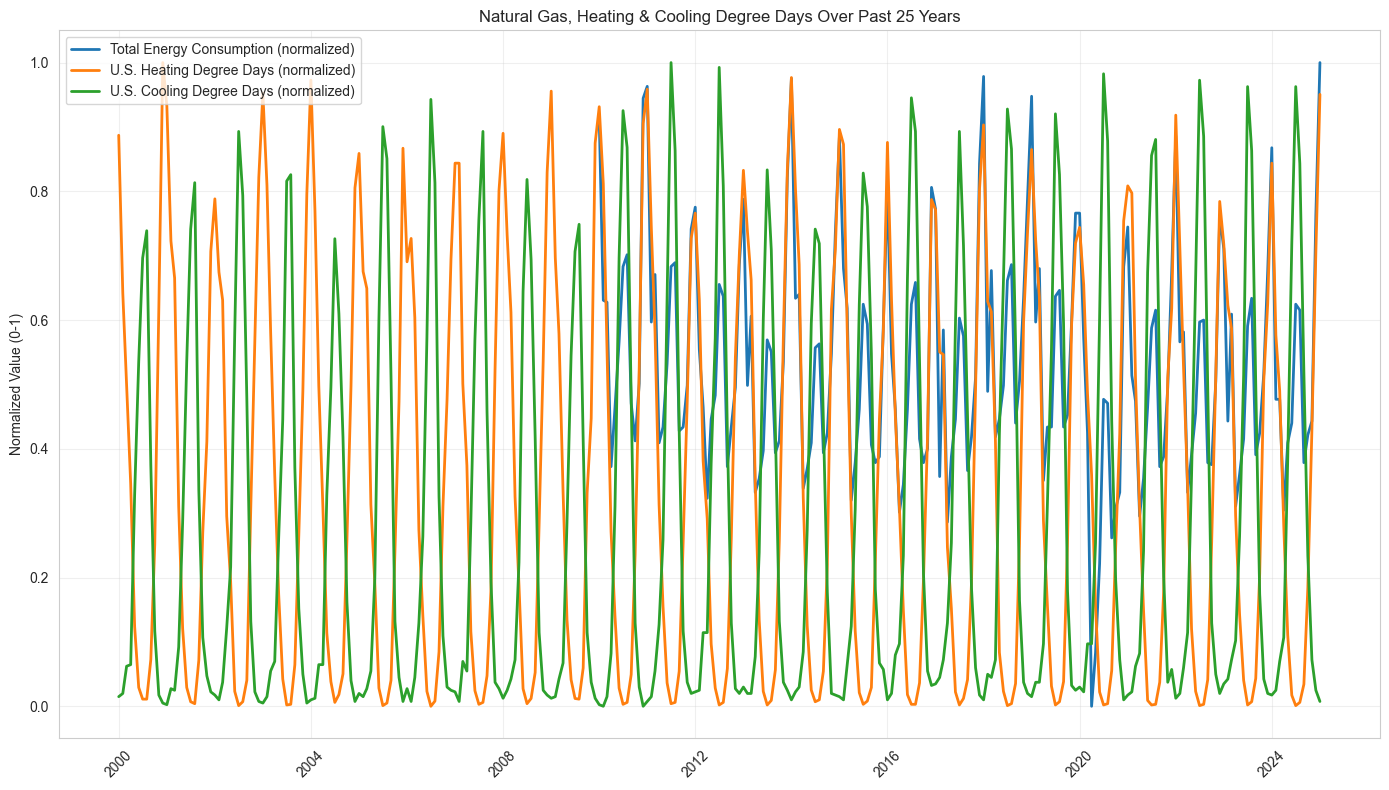

In [70]:

plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('USMonthlyEnergy.csv', skiprows=4)
df.columns = df.columns.str.strip('"\'')

# Step 3: Extract actual data rows (filter out headers and empty rows)
data_rows = df[~df['remove'].isin(['', 'Energy Production', '1. U.S. Energy Markets Summary'])].copy()
data_rows = data_rows[~data_rows['remove'].isna()]

date_columns = df.columns[6:]  # Based on file structure

# Create a list to hold transformed data
transformed_data = []

# Process each data row
for _, row in data_rows.iterrows():
    metric = row['remove']
    
    # Process each date column
    for date_col in date_columns:
        value = row[date_col]
        
        # Skip empty or missing values
        if pd.isna(value) or value == '' or value == '--':
            continue
            
        # Convert to numeric
        try:
            value = float(value)
        except (ValueError, TypeError):
            continue
            
        # Add to transformed data
        transformed_data.append({
            'date': date_col,  # Keep as string for now
            'metric': metric,
            'value': value
        })


ts_df = pd.DataFrame(transformed_data)
ts_df['date'] = pd.to_datetime(ts_df['date'])

ts_df = ts_df.set_index('date')

# Print summary information
# print(f"Time series data loaded successfully!")
# print(f"DataFrame shape: {ts_df.shape}")
# print(f"Date range: {ts_df.index.min()} to {ts_df.index.max()}")
# print(f"Available metrics:")
# for i, metric in enumerate(ts_df['metric'].unique(), 1):
#     print(f"  {i}. {metric}")

# Step 6: Visualization Functions

def plot_metric(metric_name, start_date=None, end_date=None, title=None, ylabel=None):
    """
    Plot a single energy metric over time.
    
    Parameters:
    metric_name (str): The name of the metric to plot
    start_date (str): Optional start date in format 'YYYY-MM-DD'
    end_date (str): Optional end date in format 'YYYY-MM-DD'
    title (str): Optional custom title
    ylabel (str): Optional y-axis label
    """
    df_subset = ts_df[ts_df['metric'] == metric_name]
    
    if start_date and end_date:
        df_subset = df_subset.loc[start_date:end_date]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_subset.index, df_subset['value'], linewidth=2)
    plt.title(title or f'{metric_name} Over Time')
    plt.ylabel(ylabel or 'Value')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add some basic stats as annotations
    avg = df_subset['value'].mean()
    plt.axhline(y=avg, color='r', linestyle='--', alpha=0.5)
    plt.annotate(f'Avg: {avg:.2f}', 
                 xy=(0.02, 0.95), 
                 xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    return plt

def plot_multiple_metrics(metrics, start_date=None, end_date=None, title=None):
    """
    Plot multiple energy metrics on the same graph for comparison.
    
    Parameters:
    metrics (list): List of metric names to plot
    start_date (str): Optional start date in format 'YYYY-MM-DD'
    end_date (str): Optional end date in format 'YYYY-MM-DD'
    title (str): Optional custom title
    """
    plt.figure(figsize=(14, 8))
    
    for metric in metrics:
        df_subset = ts_df[ts_df['metric'] == metric]
        
        if start_date and end_date:
            df_subset = df_subset.loc[start_date:end_date]
            
        # Normalize values to better compare trends
        min_val = df_subset['value'].min()
        max_val = df_subset['value'].max()
        normalized = (df_subset['value'] - min_val) / (max_val - min_val)
        
        plt.plot(df_subset.index, normalized, label=f"{metric} (normalized)", linewidth=2)
    
    plt.title(title or 'Energy Metrics Comparison (Normalized)')
    plt.ylabel('Normalized Value (0-1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt

#plot_metric('Renewables', start_date='2010-01-01', end_date='2020-01-01', 
 #           title='Renewables Production Over Time', ylabel='Million BTU')
plot_metric('Total Energy Consumption', start_date='2000-01-01', end_date='2025-01-01',)
plot_multiple_metrics(['Total Energy Consumption', 'U.S. Heating Degree Days', 'U.S. Cooling Degree Days'], start_date='2000-01-01', end_date='2025-01-01',
                      title='Natural Gas, Heating & Cooling Degree Days Over Past 25 Years')

print("\nTo use these functions, select from these metrics:")
for metric in sorted(ts_df['metric'].unique()):
    print(f"- '{metric}'")